<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [ ]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
tiktoken version: 0.8.0
torch version: 2.5.1+cu124
tqdm version: 4.67.1
tensorflow version: 2.18.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to follow instructions better

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below, we format the input that we will pass as input to the LLM

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- A formatted response with input field looks like as shown below

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- Below is a formatted response without an input field

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [10]:
"""Exercise 7.1"""
"""After fine-tuning the model with the Alpaca prompt style, try the Phi-3. Observe whether it affects the response quality of the model."""
"""I'll just write the function for now"""

def format_input_for_phi3(entry: dict[str, str]):
    """
    Format the input text for Phi-3.
    """

    instruction_no_period = entry['instruction'].rstrip(".")
    output_no_period = entry['output'].rstrip("'.") # TODO this might be too hacky.
    intruction_text = (
        "<|user|>\n"
        f"{instruction_no_period}: '{entry['input']}'\n"
        "\n"
        "<|assistant|>\n"
        f"{output_no_period}'."
    )
    return intruction_text

print(format_input_for_phi3(train_data[50]))

<|user|>
Identify the correct spelling of the following word: 'Ocassion'

<|assistant|>
The correct spelling is 'Occasion'.


## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

In [11]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- Similar to chapter 6, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- Also similar to the previous chapter, we use the `<|endoftext|>` token as a padding token

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- In chapter 6, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [13]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [15]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [17]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

In [19]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss

In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- Let's see what happens if we replace the class label of one of the examples with -100

In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [23]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [24]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [25]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's see what the dimensions of the resulting input and target batches look like

In [26]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [27]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [28]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [ ]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 9.15kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.12MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 30.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [02:00<00:00, 11.8MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 2.59MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 4.15MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.76MiB/s]


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [30]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [36]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

# model.to("cuda") # needs additional work
# model.to("cpu") # had to run once to fix it 

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

In [37]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 7.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters

In [38]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)

In [39]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259091854095457
Validation loss: 3.761933612823486


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [40]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

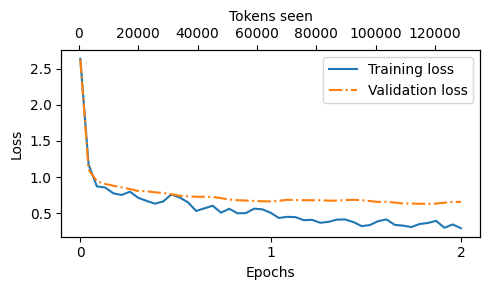

In [41]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

In [42]:
# Reminder
"""Exercise 7.2"""
"""After you train the model, but before using hte Alpaca dataset, set the
instructions to be masked with -100 and see if it improves performance."""

"""Exercise 7.3"""
"""Use the Alpaca dataset to fine tune a model."""


'Use the Alpaca dataset to fine tune a model.'

## 7.7 Extracting and saving responses

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [43]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [44]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:08<00:00,  1.62it/s]


- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [45]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- Finally, we also save the model in case we want to reuse it in the future

In [46]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the finetuned LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [47]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [48]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [ ]:
import urllib.request


def query_model_old(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {  # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048,
            "stream": False,
        },
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            print(response)
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


def query_model(prompt, 
        model = "openhermes-2.5-mistral-7b",
        url = "http://localhost:1234/v1/chat/completions"
        # model="llama3",
        # url="http://localhost:11434/api/chat"
    ):
    # Create the data payload as a dictionary
    # print(f"{prompt=} {model=} {url=}")
    headers = {"Content-Type": "application/json"}
    data = {
        "model": model,
        "messages": [
            {"role": "system", "content": "Answer simply."},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0,
        "stream": False,
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, headers=headers, method="POST")
    # request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.read().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            # print(response_json)
            response_data += response_json["choices"][0]["message"]["content"]

    return response_data


# model = "llama3"
# model = "openhermes-2.5-mistral-7b"
# url = "http://localhost:1234/v1/chat/completions"
# result = query_model("What do Llamas eat?", model=model, url=url)
result = query_model("What do Llamas eat?")
print(result)

prompt='What do Llamas eat?' model='openhermes-2.5-mistral-7b' url='http://localhost:1234/v1/chat/completions'
Llamas are herbivores and primarily eat grasses, leaves, and other plant material.


- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [72]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the sentence using a simile.\n\n### Input:\nThe car is very fast.` and correct output `The car is as fast as lightning.`, score the model response `The car is as fast as a bullet.` on a scale from 0 to 100, where 100 is the best score. ' model='openhermes-2.5-mistral-7b' url='http://localhost:1234/v1/chat/completions'
>> 85

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Score:
prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat type of cloud is typic

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop

In [73]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")
"""Ollama took 10m"""
"""Let's see how long LM Studio takes."""

Scoring entries:   0%|          | 0/110 [00:00<?, ?it/s]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the sentence using a simile.\n\n### Input:\nThe car is very fast.` and correct output `The car is as fast as lightning.`, score the model response `The car is as fast as a bullet.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   1%|          | 1/110 [00:02<04:11,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat type of cloud is typically associated with thunderstorms?` and correct output `The type of cloud typically associated with thunderstorms is cumulonimbus.`, score the model response `The type of cloud associated with thunderstorms is a cumulus cloud.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   2%|▏         | 2/110 [00:04<04:03,  2.25s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nName the author of 'Pride and Prejudice'.` and correct output `Jane Austen.`, score the model response `The author of 'Pride and Prejudice' is Jane Austen.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   3%|▎         | 3/110 [00:06<04:07,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the periodic symbol for chlorine?` and correct output `The periodic symbol for chlorine is Cl.`, score the model response `The periodic symbol for chlorine is CH3.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   4%|▎         | 4/110 [00:09<04:00,  2.27s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCorrect the punctuation in the sentence.\n\n### Input:\nIts time to go home.` and correct output `The corrected sentence should be: 'It's time to go home.'`, score the model response `It's time to go home.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   5%|▍         | 5/110 [00:11<04:03,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the sentence.\n\n### Input:\nThe lecture was delivered in a clear manner.` and correct output `The lecture was delivered clearly.`, score the model response `The lecture was delivered in a clear manner.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   5%|▌         | 6/110 [00:13<03:57,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a humorous anecdote.` and correct output `Why was the math book sad? Because it had too many problems!`, score the model response `I was at a party last night. A few friends of mine were having a good time. One of them said, "I\'m so tired I could sleep for a year."` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   6%|▋         | 7/110 [00:16<03:57,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling: 'recieve' or 'receive'.` and correct output `The correct spelling is 'receive'.`, score the model response `The correct spelling is 'receive'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   7%|▋         | 8/110 [00:18<03:49,  2.25s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a sentence using the word 'nostalgia'.` and correct output `Nostalgia washed over her as she looked through the old photos.`, score the model response `I was very nostalgic for my childhood.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   8%|▊         | 9/110 [00:20<03:47,  2.25s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the following numbers as prime or composite.\n\n### Input:\n: 11, 14, 19.` and correct output `Prime numbers: 11, 19\nComposite numbers: 14`, score the model response `Prime numbers: 11, 14, 19\nComposite numbers: 19` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:   9%|▉         | 10/110 [00:22<03:41,  2.21s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the capital of Denmark?` and correct output `The capital of Denmark is Copenhagen.`, score the model response `The capital of Denmark is Copenhagen.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  10%|█         | 11/110 [00:24<03:39,  2.22s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'wet'?` and correct output `The opposite of 'wet' is 'dry'.`, score the model response `The opposite of 'wet' is 'dry'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  11%|█         | 12/110 [00:27<03:38,  2.23s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the type of sentence.\n\n### Input:\nDid you finish the report?` and correct output `The type of sentence is interrogative.`, score the model response `The type of sentence is imperative.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  12%|█▏        | 13/110 [00:29<03:34,  2.21s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the chemical symbol for mercury?` and correct output `Hg.`, score the model response `The chemical symbol for mercury is Hg.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  13%|█▎        | 14/110 [00:31<03:38,  2.27s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the process of active transport in cells.` and correct output `Active transport is the movement of molecules across a cell membrane from a region of lower concentration to a region of higher concentration, using energy in the form of ATP. This process is crucial for maintaining cellular homeostasis.`, score the model response `Transport is the movement of substances through a given area of a cell membrane. It typically occurs by chemical means, such as movement of molecules through a membrane.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  14%|█▎        | 15/110 [00:33<03:36,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the following items as either solid, liquid, or gas.\n\n### Input:\nMercury, oxygen, wood` and correct output `Mercury - Liquid\nOxygen - Gas\nWood - Solid`, score the model response `Solid: Mercury\nLiquid: Oxygen\nGas: Wood` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  15%|█▍        | 16/110 [00:36<03:34,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 3 kilometers to meters.` and correct output `3 kilometers is 3000 meters.`, score the model response `3 kilometers is 3000 meters.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  15%|█▌        | 17/110 [00:38<03:31,  2.27s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the sentence to use an indefinite pronoun.\n\n### Input:\nSomeone left a note.` and correct output `A note was left by someone.`, score the model response `A note was left by someone.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  16%|█▋        | 18/110 [00:40<03:32,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nProvide a synonym for 'excited'.` and correct output `A synonym for 'excited' is 'thrilled'.`, score the model response `A synonym for 'excited' is 'enthusiastic'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  17%|█▋        | 19/110 [00:43<03:27,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence that follows the pattern: "Never have I ever _____ without _____"` and correct output `Never have I ever traveled without a map.`, score the model response `Never have I ever had without having.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  18%|█▊        | 20/110 [00:45<03:27,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nPick out the adjective from the following list.\n\n### Input:\nrun, tall, quickly` and correct output `The correct adjective from the list is 'tall.'`, score the model response `The adjective from the list is 'quick'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  19%|█▉        | 21/110 [00:47<03:23,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 1000 grams to kilograms.` and correct output `1000 grams is equal to 1 kilogram.`, score the model response `1000 grams is 0.1 kilograms.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  20%|██        | 22/110 [00:50<03:22,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'deep'?` and correct output `The opposite of 'deep' is 'shallow'.`, score the model response `The opposite of 'deep' is 'light'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  21%|██        | 23/110 [00:52<03:18,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the given list of animals.\n\n### Input:\nShark, Dolphin, Trout` and correct output `Fish: Shark, Trout\nMammals: Dolphin`, score the model response `Animals in the list: Shark, Dolphin, Trout` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  22%|██▏       | 24/110 [00:54<03:18,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'library' into Spanish.` and correct output `The Spanish word for 'library' is 'biblioteca'.`, score the model response `The Spanish translation of 'library' is 'libraries'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  23%|██▎       | 25/110 [00:56<03:14,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDefine the term 'hyperbole'.` and correct output `Hyperbole is a figure of speech that involves an exaggeration of ideas for the sake of emphasis.`, score the model response `Hyperbole is a word used to describe a statement that is exaggerated or exaggerated in order to make it more dramatic or dramaticistic.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  24%|██▎       | 26/110 [00:59<03:14,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'Hello' into Russian.` and correct output `Привет (Privet)`, score the model response `The Russian translation of 'Hello' is 'Русский просторавляет' (Vyacheslav 'Boris' Bilibin).` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  25%|██▍       | 27/110 [01:01<03:09,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDefine the term 'kinetic energy'.` and correct output `Kinetic energy is the energy that an object possesses due to its motion.`, score the model response `Kinetic energy is the force that can be applied to an object or person at a distance.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  25%|██▌       | 28/110 [01:03<03:09,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'hot'?` and correct output `The opposite of 'hot' is 'cold'.`, score the model response `The opposite of 'hot' is 'cold'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  26%|██▋       | 29/110 [01:06<03:05,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 5 miles to kilometers.` and correct output `5 miles is approximately 8.05 kilometers.`, score the model response `5 miles is 5000 meters.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  27%|██▋       | 30/110 [01:08<03:04,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the chemical formula for magnesium sulfate?` and correct output `The chemical formula for magnesium sulfate is MgSO4.`, score the model response `The chemical formula for magnesium sulfate is MgSO4.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  28%|██▊       | 31/110 [01:10<03:01,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence to replace any cliché phrases.\n\n### Input:\nIt's a piece of cake` and correct output `It's very easy.`, score the model response `.\n\n\nA piece of cake is a cake.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  29%|██▉       | 32/110 [01:17<04:51,  3.74s/it]

Could not convert score: ```python
def rewrite_cliche(sentence):
    cliches = {
        "a piece of cake": "very easy",
        "break a leg": "good luck",
        "bite the bullet": "endure something unpleasant",
        "cool as a cucumber": "calm and composed",
        "cost an arm and a leg": "expensive",
        "cry over spilled milk": "regret something that cannot be changed",
        "dead as a doornail": "completely dead",
        "don't count your chickens before they hatch": "don't assume something will happen until it actually does",
        "easy as pie": "not difficult",
        "hit the nail on the head": "be exactly right",
        "in a pickle": "in a difficult situation",
        "kick the bucket": "die",
        "let the cat out of the bag": "reveal a secret",
        "once in a blue moon": "rarely",
        "piece of cake": "easy",
        "pull someone's leg": "tease someone",
        "the ball is in your court": "it's now someone else's turn to do something",
   

Scoring entries:  30%|███       | 33/110 [01:20<04:13,  3.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 7 kilometers to meters.` and correct output `7 kilometers is 7000 meters.`, score the model response `7 kilometers is 7.07 miles.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  31%|███       | 34/110 [01:22<03:48,  3.01s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'heavy'?` and correct output `The opposite of 'heavy' is 'light'.`, score the model response `The opposite of 'heavy' is 'light'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  32%|███▏      | 35/110 [01:24<03:28,  2.78s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the past tense of 'sing'?` and correct output `The past tense of 'sing' is 'sang.'`, score the model response `The past tense of 'sing' is 'to sing.'` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  33%|███▎      | 36/110 [01:27<03:16,  2.66s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the molecular formula for carbon dioxide?` and correct output `The molecular formula for carbon dioxide is CO2.`, score the model response `The molecular formula for carbon dioxide is CO2.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  34%|███▎      | 37/110 [01:29<03:04,  2.53s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert this sentence to passive voice\n\n### Input:\nThe gardener watered the plants.` and correct output `The plants were watered by the gardener.`, score the model response `The plants were watered by the gardener.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  35%|███▍      | 38/110 [01:31<02:59,  2.49s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the past tense of 'throw'?` and correct output `The past tense of 'throw' is 'threw'.`, score the model response `The past tense of 'throw' is 'threw'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  35%|███▌      | 39/110 [01:33<02:51,  2.42s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nExplain what a sonnet is.` and correct output `A sonnet is a 14-line poem with a specific rhyme scheme and meter, often written in iambic pentameter.`, score the model response `A sonnet is a poem that begins with the words 'I sing.'` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  36%|███▋      | 40/110 [01:36<02:47,  2.39s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'innovative'.` and correct output `The company is known for its innovative products.`, score the model response `She was very innovative and always had a smile on her face.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  37%|███▋      | 41/110 [01:38<02:41,  2.34s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nProvide the plural form of 'cactus'.` and correct output `The plural form of 'cactus' is 'cacti'.`, score the model response `The plural form of 'cactus' is 'cacti'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  38%|███▊      | 42/110 [01:40<02:40,  2.35s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate the phrase 'Where is the bathroom?' into German.` and correct output `The German translation of 'Where is the bathroom?' is 'Wo ist die Toilette?'`, score the model response `The German translation of 'Where is the bathroom?' is 'Wie es?'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  39%|███▉      | 43/110 [01:43<02:35,  2.33s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a past-tense verb that describes a person laughing.` and correct output `Laughed.`, score the model response `She laughed.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  40%|████      | 44/110 [01:45<02:33,  2.33s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'transient.'` and correct output `The transient nature of her visit left a lasting impression.`, score the model response `She was transported from the park to the library.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  41%|████      | 45/110 [01:47<02:29,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'optimistic'.` and correct output `He remained optimistic despite the challenges he faced.`, score the model response `She was optimistic about the future.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  42%|████▏     | 46/110 [01:50<02:28,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRe-word this sentence using an indirect question.\n\n### Input:\nWhat time is the meeting?` and correct output `Could you tell me what time the meeting is?`, score the model response `The meeting is at 7:00.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  43%|████▎     | 47/110 [01:52<02:24,  2.30s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the following sentence as a statement, a question, or an exclamation.\n\n### Input:\nWhat a beautiful day!` and correct output `Exclamation.`, score the model response `A statement.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  44%|████▎     | 48/110 [01:54<02:23,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'rich'?` and correct output `The opposite of 'rich' is 'poor'.`, score the model response `The opposite of 'rich' is 'poor'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  45%|████▍     | 49/110 [01:56<02:19,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nFind a synonym for the given verb.\n\n### Input:\nBegin` and correct output `Commence`, score the model response `Begin` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  45%|████▌     | 50/110 [01:59<02:18,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nEdit the given text to ensure all plural nouns are spelled correctly.\n\n### Input:\nThe birds sings beautiful songs.` and correct output `The birds sing beautiful songs.`, score the model response `The birds are singing beautiful songs.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  46%|████▋     | 51/110 [02:01<02:14,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTransform the following sentence into a question using "could."\n\n### Input:\nYou can help me tomorrow.` and correct output `Could you help me tomorrow?`, score the model response `Could you help me tomorrow?` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  47%|████▋     | 52/110 [02:03<02:14,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the following items: bicycle, rose, tiger.` and correct output `Vehicles: Bicycle\nPlants: Rose\nAnimals: Tiger`, score the model response `Animals: Tiger\nPlants: Rose\nPlants: Bicycle\nAnimals: Tiger\nPlants: Rose\nPlants: Bicycle` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  48%|████▊     | 53/110 [02:06<02:11,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDefine the term 'irony'.` and correct output `Irony is a figure of speech in which words are used in such a way that their intended meaning is different from the actual meaning of the words.`, score the model response `The term 'irony' is a synonym for 'silly'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  49%|████▉     | 54/110 [02:08<02:09,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'Welcome' into German.` and correct output `The German translation of 'Welcome' is 'Willkommen'.`, score the model response `The German translation of 'Welcome' is 'Wie es tut mir?'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  50%|█████     | 55/110 [02:10<02:05,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nExplain the primary function of the human heart.` and correct output `The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.`, score the model response `The primary function of the human heart is to pump blood to the brain and to return carbon dioxide and oxygen to the body.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  51%|█████     | 56/110 [02:13<02:04,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nReword the following sentence to the future tense.\n\n### Input:\nHe is reading a novel inspired by his grandmother.` and correct output `He will be reading a novel inspired by his grandmother.`, score the model response `He is reading a novel inspired by his grandmother.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  52%|█████▏    | 57/110 [02:15<02:01,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the given sentence into active voice.\n\n### Input:\nThe law was passed by the government.` and correct output `The government passed the law.`, score the model response `The law was passed by the government.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  53%|█████▎    | 58/110 [02:17<01:59,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a sentence using the word 'inevitable'.` and correct output `The confrontation was inevitable given the circumstances.`, score the model response `The storm was inevitable.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  54%|█████▎    | 59/110 [02:19<01:56,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCategorize the following sentence as either factual or opinion-based.\n\n### Input:\nChocolate is the best dessert.` and correct output `Opinion-based.`, score the model response `Categorize the following sentence as either factual or opinion-based.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  55%|█████▍    | 60/110 [02:22<01:56,  2.32s/it]

Could not convert score: Opinion-based
prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is an antonym of 'old'?` and correct output `young.`, score the model response `An antonym of 'old' is 'young'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  55%|█████▌    | 61/110 [02:24<01:53,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nProvide a synonym for 'hardworking'.` and correct output `A synonym for 'hardworking' is 'diligent'.`, score the model response `A synonym for 'hardworking' is 'smart'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  56%|█████▋    | 62/110 [02:26<01:49,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the boiling point of sulfur in Celsius?` and correct output `The boiling point of sulfur is 444.6 degrees Celsius.`, score the model response `The boiling point of sulfur is -114.5 degrees Celsius.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  57%|█████▋    | 63/110 [02:29<01:47,  2.28s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the plural form of 'child'?` and correct output `The plural form of 'child' is 'children'.`, score the model response `The plural form of 'child' is 'chunk'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  58%|█████▊    | 64/110 [02:31<01:46,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is an antonym of 'complicated'?` and correct output `An antonym of 'complicated' is 'simple'.`, score the model response `An antonym of 'complicated' is 'simplified'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  59%|█████▉    | 65/110 [02:33<01:42,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nName three forms of water.` and correct output `The three forms of water are solid (ice), liquid (water), and gas (steam).`, score the model response `Three forms of water are water vapor, water, and water vapor.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  60%|██████    | 66/110 [02:36<01:41,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite this sentence as a question.\n\n### Input:\nThe dog chased the cat.` and correct output `Did the dog chase the cat?`, score the model response `What is the cat chasing?` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  61%|██████    | 67/110 [02:38<01:38,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nSplit the following sentence into two declarative sentences: 'The movie was long but interesting.'` and correct output `The movie was long. It was interesting.`, score the model response `The movie was interesting.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  62%|██████▏   | 68/110 [02:40<01:37,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the following substances as acid, base, or neutral.\n\n### Input:\nLemon juice, Soap, Water` and correct output `Acid: Lemon juice\nBase: Soap\nNeutral: Water`, score the model response `Acid: Soap\nBase: Soap\nNegative: Water` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  63%|██████▎   | 69/110 [02:42<01:33,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a synonym of 'sad'?` and correct output `A synonym for 'sad' is 'unhappy'.`, score the model response `A synonym for 'sad' is 'angry'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  64%|██████▎   | 70/110 [02:45<01:32,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCorrect any spelling mistakes in the given sentence.\n\n### Input:\nI prefer homemade cookies to store boaght.` and correct output `I prefer homemade cookies to store bought.`, score the model response `I prefer homemade cookies to store boaght.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  65%|██████▍   | 71/110 [02:47<01:29,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'transient'.` and correct output `His stay in the city was transient, lasting only a couple of days.`, score the model response `She was transported from the park to the library.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  65%|██████▌   | 72/110 [02:49<01:27,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'I am lost' into Italian.` and correct output `The Italian translation of 'I am lost' is 'Mi sono perso' (if male) or 'Mi sono persa' (if female).`, score the model response `Il più américaino.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  66%|██████▋   | 73/110 [02:52<01:24,  2.29s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify this text as a technical document or a narrative.\n\n### Input:\nThis manual provides instructions for installing the software.` and correct output `Technical document`, score the model response `Technical document.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  67%|██████▋   | 74/110 [02:54<01:23,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nSort the following list in descending order.\n\n### Input:\n10, 2, 25, 16, 7` and correct output `25, 16, 10, 7, 2.`, score the model response `, 3, 3.\n\n\nThe list of 25 is in ascending order.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  68%|██████▊   | 75/110 [02:57<01:33,  2.67s/it]

Could not convert score: ```python
def sort_list(lst):
    return sorted(lst, reverse=True)

input_list = [10, 2, 25, 16, 7]
sorted_list = sort_list(input_list)
print(sorted_list) # Output: [25, 16, 10, 7, 2]
```
prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'Can I have some water?' into French.` and correct output `Puis-je avoir de l'eau?`, score the model response `Can I have some water?` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  69%|██████▉   | 76/110 [03:00<01:26,  2.55s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a simile with the word 'as cold as'.` and correct output `Her hands were as cold as ice.`, score the model response `The temperature of 'as cold as' is -38 degrees Celsius.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  70%|███████   | 77/110 [03:02<01:20,  2.45s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify the following words by their grammatical categories: swim, beautiful, quickly` and correct output `Swim: Verb\nBeautiful: Adjective\nQuickly: Adverb`, score the model response `.\n\n\nThe following words are in the following grammatical categories: Verb, Adjective, Adverb, Adverbial, Adjective Adverb, Adverb\n\n### Input:\nswim\n\n\nThe following words are in the following grammatical categories: Adjective, Verb, Adjective, Adverb, Adverb` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  71%|███████   | 78/110 [03:04<01:18,  2.44s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCalculate the density of an object with a mass of 15 grams and a volume of 5 cubic centimeters.` and correct output `The density of the object is 3 grams per cubic centimeter.`, score the model response `The density of the object is 15 grams/cc.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  72%|███████▏  | 79/110 [03:07<01:13,  2.38s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the abbreviation for 'Master of Business Administration'?` and correct output `The abbreviation for 'Master of Business Administration' is MBA.`, score the model response `The abbreviation for 'Master of Business Administration' is MBA.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  73%|███████▎  | 80/110 [03:09<01:11,  2.37s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the following number from Roman numerals: IX.` and correct output `The number IX in Roman numerals is 9.`, score the model response `5 to decimal: 1.5.\n\n\n1.5 is a Roman numeral.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  74%|███████▎  | 81/110 [03:12<01:17,  2.66s/it]

Could not convert score: ```python
def roman_to_decimal(roman):
    if roman == "IX":
        return 9
    else:
        return 5

roman = "IX"
decimal = roman_to_decimal(roman)
print("The number IX in Roman numerals is", decimal, "in decimal.")
```
prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'horizontal'?` and correct output `The opposite of 'horizontal' is 'vertical'.`, score the model response `The opposite of 'horizontal' is 'vertical'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  75%|███████▍  | 82/110 [03:14<01:10,  2.53s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'Where can I buy tickets?' into Italian.` and correct output `The Italian translation for 'Where can I buy tickets?' is 'Dove posso comprare i biglietti?'`, score the model response `The Italian translation of 'Where can I buy tickets?' is 'Ti amo?'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  75%|███████▌  | 83/110 [03:17<01:06,  2.45s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence to replace any clichés.\n\n### Input:\nHe was as cool as a cucumber.` and correct output `He remained very calm.`, score the model response `He was as cool as a cucumber.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  76%|███████▋  | 84/110 [03:19<01:03,  2.43s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the main verb in the sentence.\n\n### Input:\nThe dog barked loudly.` and correct output `The main verb in the sentence is 'barked'.`, score the model response `The main verb in the sentence is 'bark'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  77%|███████▋  | 85/110 [03:21<00:59,  2.37s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'elucidate'.` and correct output `The professor attempted to elucidate the complex topic for his students.`, score the model response `She was able to solve the problem.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  78%|███████▊  | 86/110 [03:24<00:56,  2.36s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCorrect the sentence.\n\n### Input:\nMe and my friend went to the store.` and correct output `My friend and I went to the store.`, score the model response `We went to the store.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  79%|███████▉  | 87/110 [03:26<00:53,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the formula for calculating work done?` and correct output `The formula for calculating work done is work = force × distance.`, score the model response `The formula for calculating work done is W = (1 - H)2 + (1 - C)3 + (1 - D)4 + (1 - E)5 + (1 - F)6 + (1 - G)7 + (1 - H)8 + (1 - I)9 + (1 - J)10 + (1 - K)11 + (1 - L)12 + (1 - M)13 + (1 - N)14 + (1 - O)15 + (1 - P)16 + (1 - Q)17 + (1 - R)18 + (1 - S)19 + (1 - T)20 + (1 - U)21 + (1 - V)22 + (1 - W)23 + (1 - X)24 + (1 - Y)25 + (1 - Z)26 + (1 - W)27 + (1 - X)28 + (1 - Y)29 + (1 - Z)30 + (1 - W)31 + (1 - X)32 + (1 - Y)33 + (1 - Z)34 + (1 - W)35 + (1 -` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  80%|████████  | 88/110 [03:28<00:51,  2.36s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the chemical formula for ammonium nitrate?` and correct output `The chemical formula for ammonium nitrate is NH4NO3.`, score the model response `The chemical formula for ammonium nitrate is NH3.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  81%|████████  | 89/110 [03:31<00:48,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the molecular formula for water?` and correct output `The molecular formula for water is H2O.`, score the model response `The molecular formula for water is H2O2.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  82%|████████▏ | 90/110 [03:33<00:46,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the given sentence to describe the same thing in a positive way.\n\n### Input:\nThe food was not good.` and correct output `The food could use some improvement.`, score the model response `The food was not good.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  83%|████████▎ | 91/110 [03:35<00:43,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the opposite of 'lazy'?` and correct output `The opposite of 'lazy' is 'diligent'.`, score the model response `The opposite of 'lazy' is 'attentive'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  84%|████████▎ | 92/110 [03:38<00:41,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nName three essential vitamins for human health.` and correct output `1. Vitamin A\n2. Vitamin C\n3. Vitamin D`, score the model response `1. Vitamin B12\n2. Vitamin C\n3. Vitamin B6` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  85%|████████▍ | 93/110 [03:40<00:38,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDefine the term 'simile'.` and correct output `A simile is a figure of speech that directly compares two different things, often introduced with the words 'like' or 'as'.`, score the model response `A simile is a figurative representation of a sound.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  85%|████████▌ | 94/110 [03:42<00:37,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the boiling point of chlorine in Celsius?` and correct output `The boiling point of chlorine is -34 degrees Celsius.`, score the model response `The boiling point of chlorine is -196.5 degrees Celsius.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  86%|████████▋ | 95/110 [03:44<00:34,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'My name is' into French.` and correct output `The French translation of 'My name is' is 'Je m'appelle'.`, score the model response `The French translation of 'My name is' is 'Comment ça va?'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  87%|████████▋ | 96/110 [03:47<00:32,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 200 centimeters to meters.` and correct output `200 centimeters is 2 meters.`, score the model response `200 centimeters is 0.2 meters.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  88%|████████▊ | 97/110 [03:49<00:29,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the chemical symbol for zinc?` and correct output `Zn.`, score the model response `The chemical symbol for zinc is Zn.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  89%|████████▉ | 98/110 [03:51<00:27,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the formula for calculating force?` and correct output `The formula for calculating force is Force = mass x acceleration.`, score the model response `The formula for calculating force is (F = mv² + g)² + c².` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  90%|█████████ | 99/110 [03:54<00:25,  2.29s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'innovative'.` and correct output `The company's innovative approach set it apart from its competitors.`, score the model response `She was very innovative and always had a smile on her face.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  91%|█████████ | 100/110 [03:56<00:23,  2.31s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate a sentence using the word 'generous'.` and correct output `He is very generous and always helps those in need.`, score the model response `She was very generous and gave the poor a meal.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  92%|█████████▏| 101/110 [03:58<00:20,  2.28s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is an antonym of 'sharp'?` and correct output `An antonym of 'sharp' is 'dull'.`, score the model response `An antonym of 'sharp' is 'soft'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  93%|█████████▎| 102/110 [04:01<00:18,  2.31s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the basic structure of a neuron.` and correct output `A neuron consists of three main parts: the cell body, which contains the nucleus; dendrites, which receive signals from other neurons; and an axon, which transmits signals to other neurons, muscles, or glands.`, score the model response `A neuron is a type of synapse in the brain.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  94%|█████████▎| 103/110 [04:03<00:16,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nTranslate 'see you later' into Spanish.` and correct output `Hasta luego`, score the model response `Están leyendo see you later.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  95%|█████████▍| 104/110 [04:05<00:13,  2.30s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat are the first 10 elements of the Fibonacci sequence?` and correct output `0, 1, 1, 2, 3, 5, 8, 13, 21, 34.`, score the model response `The first 10 elements of the Fibonacci sequence are: 1, 3, 5, 7, 11, 13, 15, 21, 3, 5, 8, 11, 5, 3, 7, 9, 11.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  95%|█████████▌| 105/110 [04:07<00:11,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is an antonym of 'transparent'?` and correct output `An antonym of 'transparent' is 'opaque'.`, score the model response `An antonym of 'transparent' is 'illuminated'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  96%|█████████▋| 106/110 [04:10<00:09,  2.30s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is the past tense of 'think'?` and correct output `The past tense of 'think' is 'thought'.`, score the model response `The past tense of 'think' is 'to think'.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  97%|█████████▋| 107/110 [04:12<00:06,  2.28s/it]

prompt="Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nClassify each sentence as either declarative, interrogative, imperative, or exclamatory.\n\n### Input:\nPlease open the door.` and correct output `The classification of the sentence 'Please open the door.' is imperative.`, score the model response `Please open the door.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only." model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  98%|█████████▊| 108/110 [04:14<00:04,  2.32s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the sentence to use a negative adverb.\n\n### Input:\nShe always remembers to call.` and correct output `She never forgets to call.`, score the model response `She always remembers to call.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries:  99%|█████████▉| 109/110 [04:17<00:02,  2.28s/it]

prompt='Given the input `Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert 50 miles per hour to kilometers per hour.` and correct output `50 miles per hour is approximately 80.47 kilometers per hour.`, score the model response `50 miles per hour is approximately 32.5 kilometers per hour.` on a scale from 0 to 100, where 100 is the best score. Respond with the integer number only.' model='llama3' url='http://localhost:1234/v1/chat/completions'


Scoring entries: 100%|██████████| 110/110 [04:19<00:00,  2.36s/it]

Number of scores: 106 of 110
Average score: 67.44



- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above

- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.9 Conclusions

### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)

## What's next?

- Congrats on completing the book; in case you are looking for additional resources, I added several bonus sections to this GitHub repository that you might find interesting
- The complete list of bonus materials can be viewed in the main README's [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section
- To highlight a few of my favorites:
  1. [Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) implements a popular preference tuning mechanism to align the model from this chapter more closely with human preferences
  2. [Llama 3.2 From Scratch (A Standalone Notebook)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb), a from-scratch implementation of Meta AI's popular Llama 3.2, including loading the official pretrained weights; if you are up to some additional experiments, you can replace the `GPTModel` model in each of the chapters with the `Llama3Model` class (it should work as a 1:1 replacement)
  3. [Converting GPT to Llama](../../ch05/07_gpt_to_llama) contains code with step-by-step guides that explain the differences between GPT-2 and the various Llama models
  4. [Understanding the Difference Between Embedding Layers and Linear Layers](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) is a conceptual explanation illustrating that the `Embedding` layer in PyTorch, which we use at the input stage of an LLM, is mathematically equivalent to a linear layer applied to one-hot encoded data
- Happy further reading!